In [214]:
from dataclasses import dataclass, field
from typing import List, Dict, Tuple
from random import uniform, randint
import matplotlib.pyplot as plt

mutation_strength = 0.15
world_size = 200
reproduction_cost = 25.0
per_step_food_spawn = 2000
idle_cost = 5.0

In [215]:
@dataclass(slots=True)
class Creature:
    simulation: 'Simulation'
    x: int = field(default_factory=lambda: randint(0, world_size))
    y: int = field(default_factory=lambda: randint(0, world_size))
    energy: float = field(default_factory=lambda: uniform(75.0, 1500.0))
    age: int = 0
    
    # genetic parameters
    speed: float = field(default_factory=lambda: uniform(1.0, 5.0))
    eat_range: float = field(default_factory=lambda: uniform(0.1, 2.0))
    reproduction_chance: float = field(default_factory=lambda: uniform(0.1, 0.7))
    view_range: float = field(default_factory=lambda: uniform(0.1, 1.0))
    life_span: float = 0.0
    
    def step(self):
        self.idle()
        if self.try_eat():
            pass
        else:
            target = self.find_target()
            if target:
                self.move_to(target)
            else:
                self.random_move()
        if self.energy > reproduction_cost:
            self.try_reproduce()
        self.age += 1
        self.clamp_position()
        if self.life_span > 0 and self.age > self.life_span:
            self.die()
        if self.energy < 0:
            self.die()
    
    def clamp_position(self):
        self.x = max(0, min(world_size, self.x))
        self.y = max(0, min(world_size, self.y))
        
    def idle(self):
        self.energy -= idle_cost
        self.energy -= self.speed * 0.2
        self.energy -= self.view_range * 0.03
        self.energy -= self.eat_range * 0.03
        
    def die(self):
        self.simulation.delete(self)
        
    def try_eat(self):
        targets = self.simulation.food_in_range(self.x, self.y, self.eat_range * 5)
        targets.sort(key=lambda x: x[2], reverse=True)
        if targets:
            for target in targets:
                self.energy += max(0, target[2])
                self.simulation.eat(target[0], target[1])    
            return True
        else:
            return False
    
    def find_target(self):
        targets = self.simulation.food_in_range(self.x, self.y, self.view_range * 100)
        targets.sort(key=lambda x: x[2], reverse=True)
        if targets:
            return targets[0][:2]
        else:
            return None
        
    def move_to(self, target):
        dx = target[0] - self.x
        dy = target[1] - self.y
        d = (dx**2 + dy**2)**0.5
        dx /= d
        dy /= d
        self.x += int(dx * self.speed * 10)
        self.y += int(dy * self.speed * 10)
    
    def random_move(self):
        self.x += int(uniform(-1, 1) * self.speed * 10)
        self.y += int(uniform(-1, 1) * self.speed * 10)
        
    def try_reproduce(self):
        if uniform(0, 1) < self.reproduction_chance:
            self.reproduce()
            
    def reproduce(self):
        self.energy -= reproduction_cost
        child = Creature(self.simulation, self.x, self.y, self.energy / 2)
        child.mutate()
        self.simulation.spawn(child)
        
    def mutate(self):
        self.speed += uniform(-mutation_strength, mutation_strength)
        self.eat_range += uniform(-mutation_strength, mutation_strength)
        self.reproduction_chance += uniform(-mutation_strength, mutation_strength)
        self.view_range += uniform(-mutation_strength, mutation_strength)
        self.life_span += uniform(-5, 30)
        
        self.speed = max(0, self.speed)
        self.eat_range = max(0, self.eat_range)
        self.reproduction_chance = max(0, self.reproduction_chance)
        self.reproduction_chance = min(1, self.reproduction_chance)
        self.view_range = max(0, self.view_range)
        self.life_span = max(0, self.life_span)
    

@dataclass(slots=True)
class Simulation:
    creatures: List[Creature] = field(default_factory=list)
    food: Dict[Tuple[int, int], float] = field(default_factory=dict)
    time: int = 0
    
    def init(self, creatures: int, food: int):
        for _ in range(creatures):
            self.spawn(Creature(self))
        for _ in range(food):
            self.spawn_food()
    
    def spawn_food(self):
        self.food[(randint(0, world_size), randint(0, world_size))] = uniform(50.0, 100.0)
    
    def food_in_range(self, x: int, y: int, r: float) -> List[Tuple[int, int, float]]:
        return [(fx, fy, self.food[(fx, fy)]) for fx, fy in self.food.keys() if (fx - x)**2 + (fy - y)**2 <= r**2]
    
    def eat(self, x: int, y: int):
        del self.food[(x, y)]
    
    def spawn(self, creature: Creature):
        self.creatures.append(creature)
        
    def delete(self, creature: Creature):
        if creature in self.creatures:
            self.creatures.remove(creature)
        
    def step(self):
        self.time += 1
        for creature in self.creatures:
            creature.step()
        for _ in range(per_step_food_spawn):
            self.spawn_food()
        
    def spawn_food(self):
        if uniform(0, 1) < 0.01:
            self.food[(randint(0, world_size), randint(0, world_size))] = uniform(1.0, 10.0)
        
    def make_plot(self):
        plt.figure(figsize=(10, 10))
        plt.xlim(0, world_size)
        plt.ylim(0, world_size)
        plt.scatter([c.x for c in self.creatures], [c.y for c in self.creatures], s=[c.energy for c in self.creatures], color='red')
        plt.scatter([x for x, y in self.food.keys()], [y for x, y in self.food.keys()], s=[v for v in self.food.values()], color='green')
        plt.title(f"Simulation time: {self.time}, creatures: {len(self.creatures)}, food: {len(self.food)}")
        plt.show()
        
    @property
    def avg_life_span(self):
        if not self.creatures:
            return 0
        return sum(c.life_span for c in self.creatures) / len(self.creatures)
    
    @property
    def zero_life_span_count(self):
        return sum(1 for c in self.creatures if c.life_span == 0)
    
    @property
    def non_zero_life_span_count(self):
        return sum(1 for c in self.creatures if c.life_span > 0)

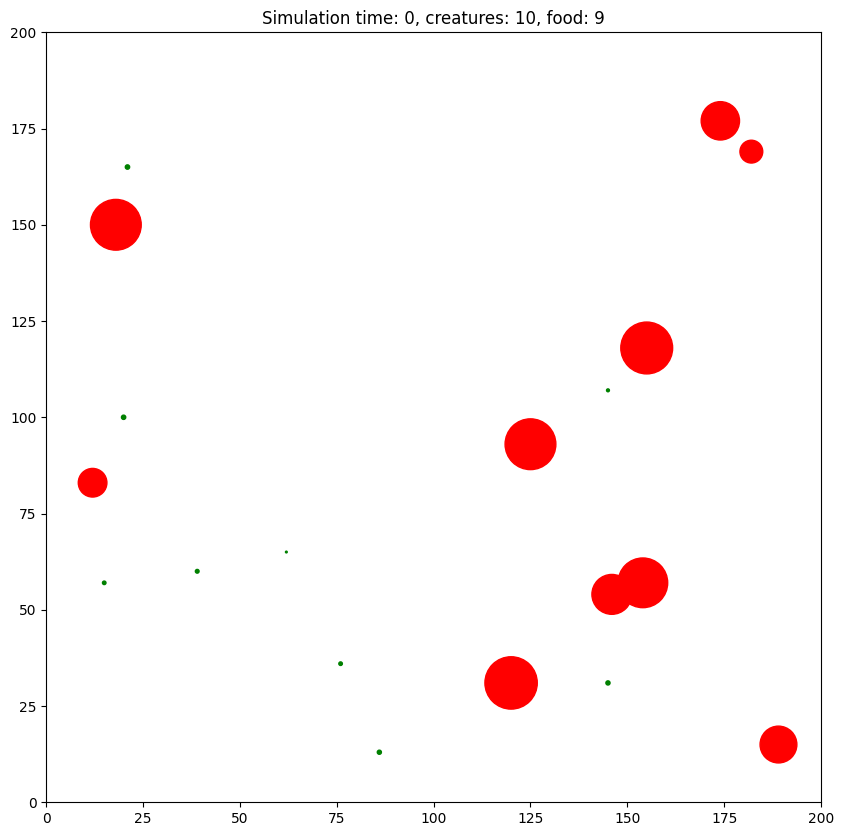

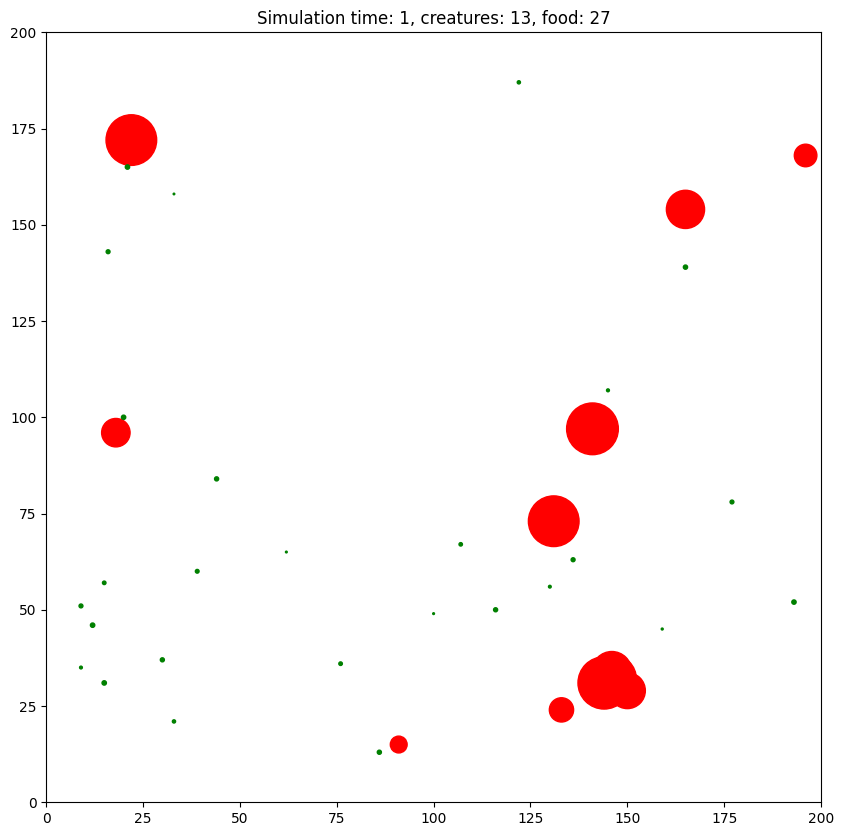

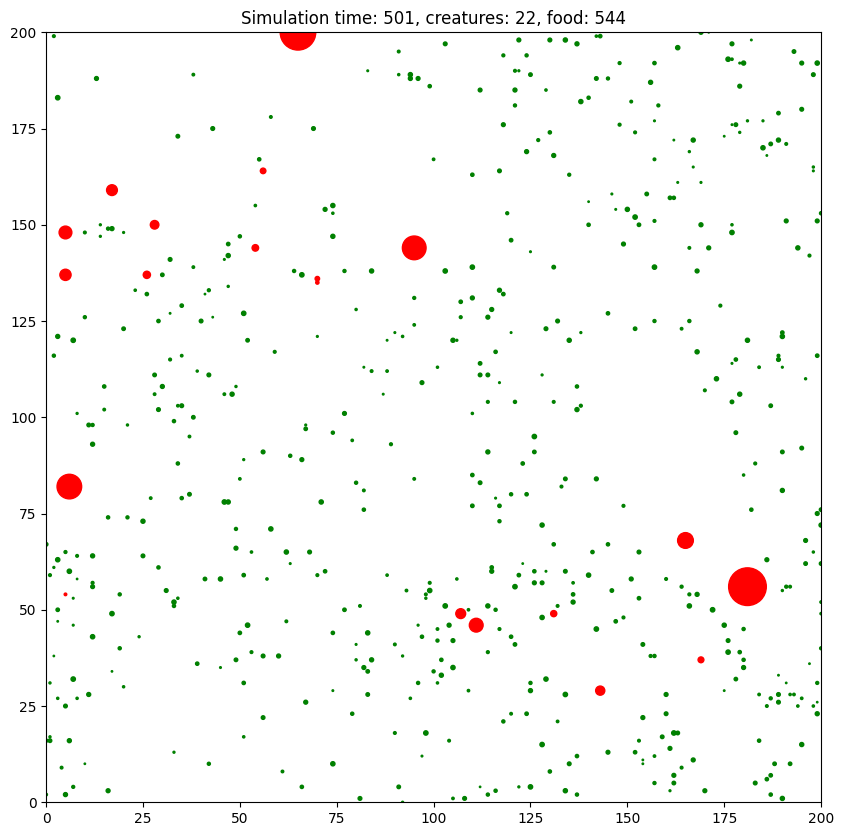

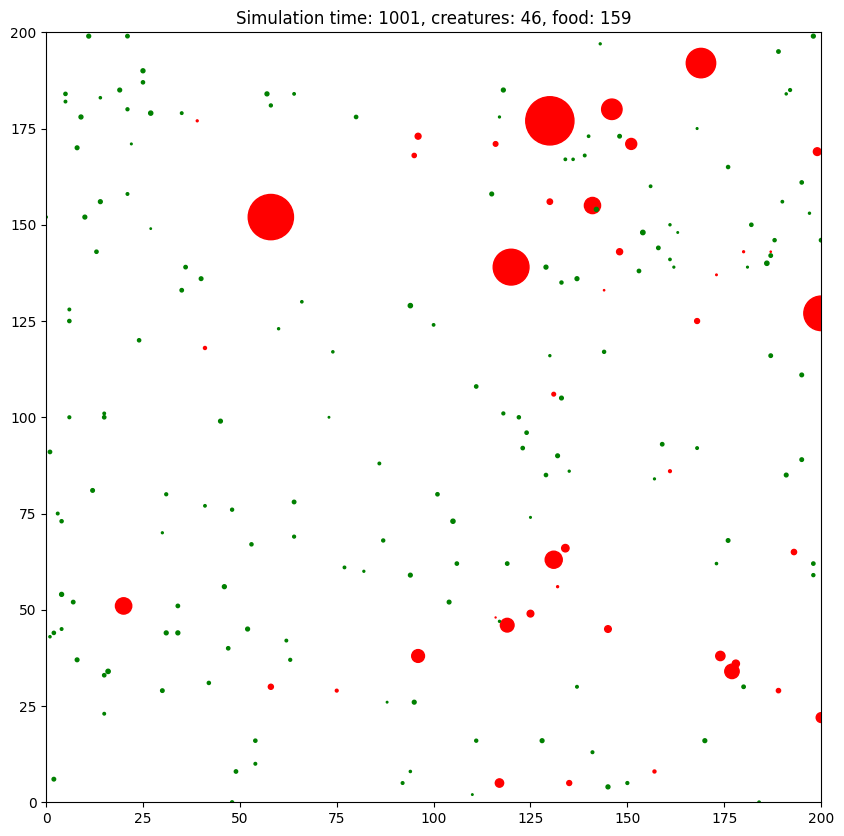

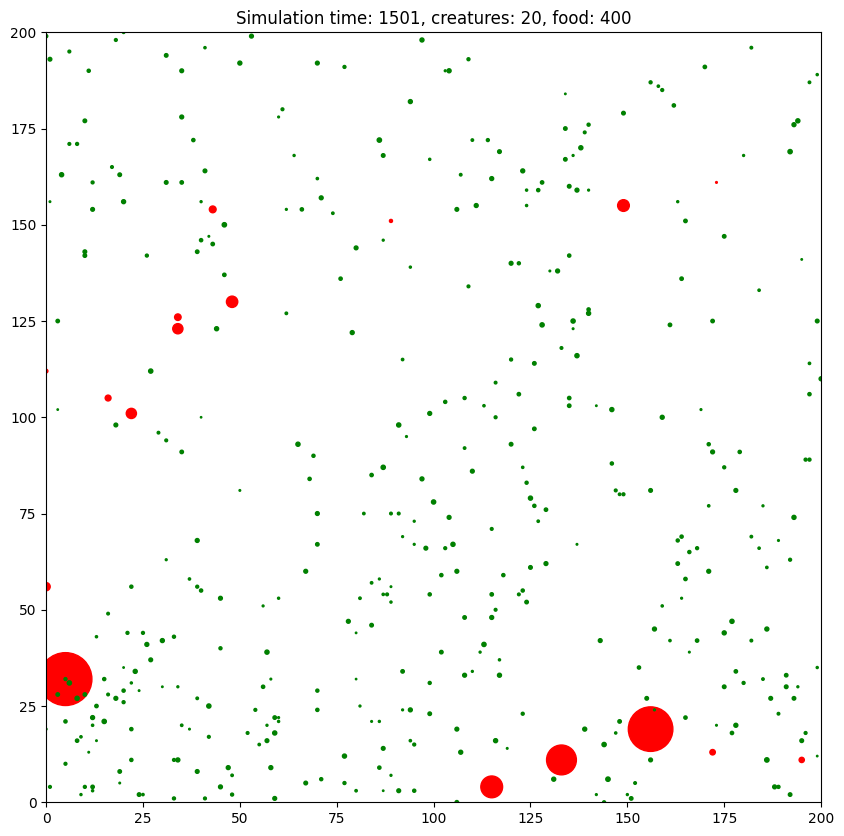

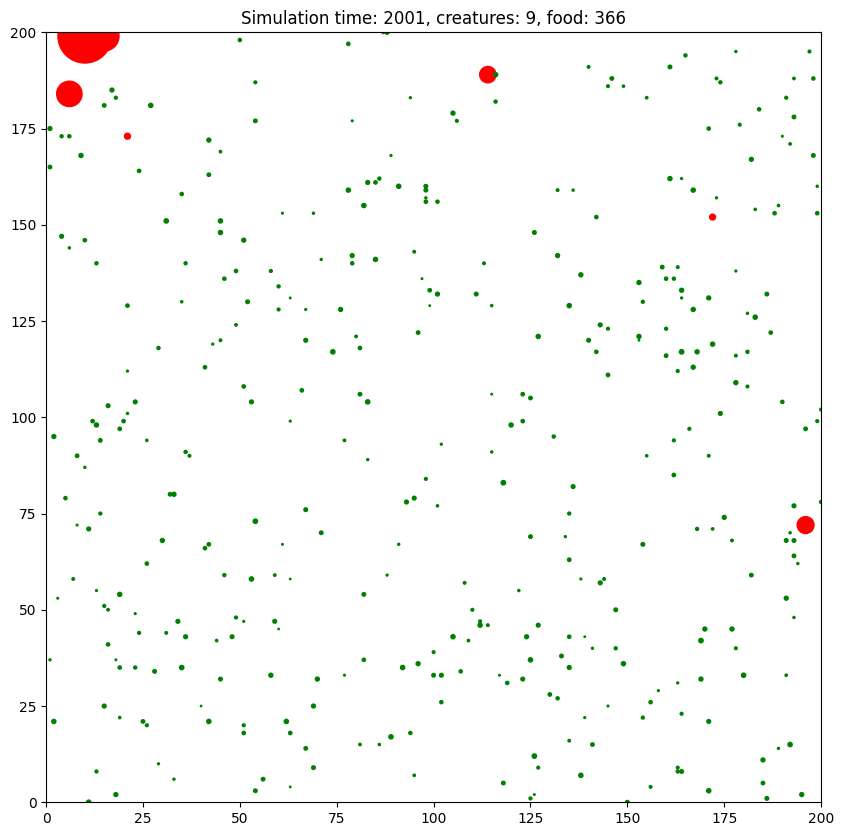

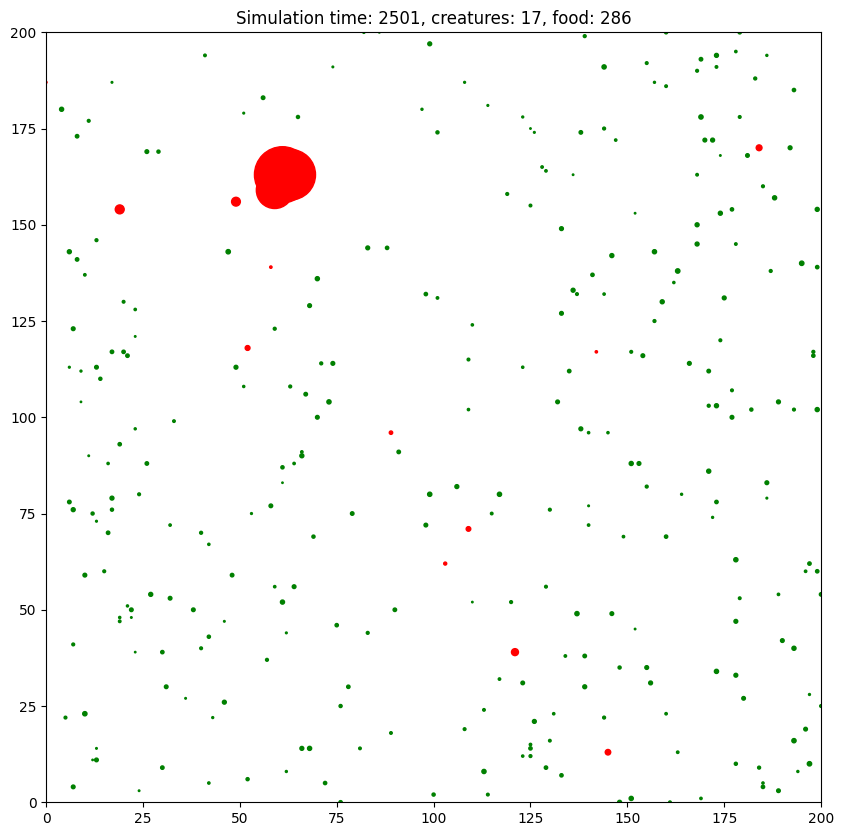

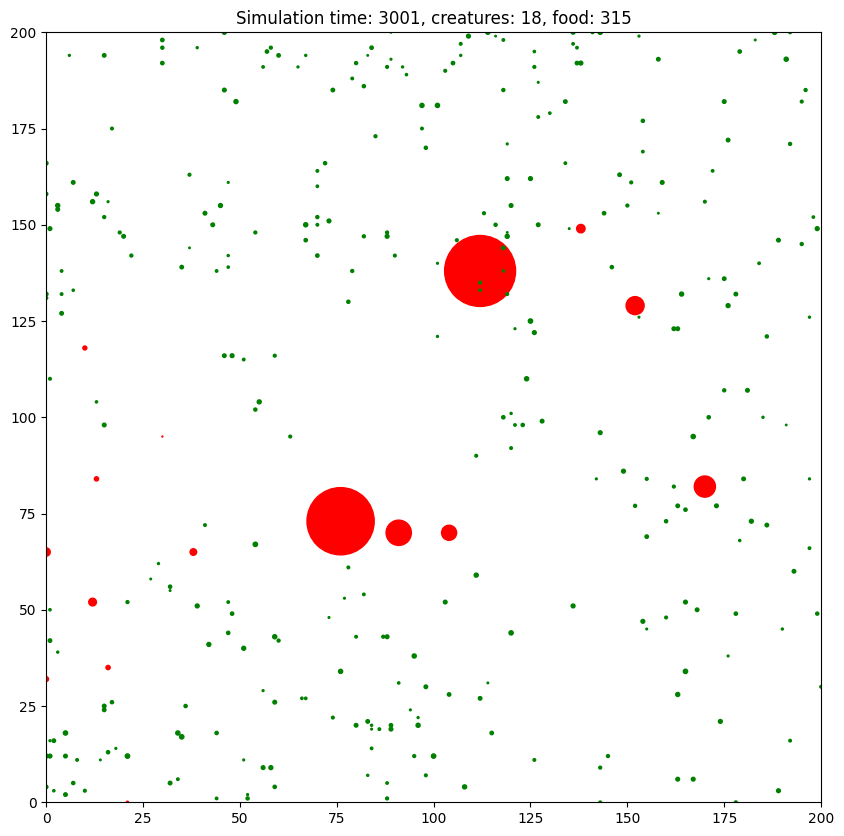

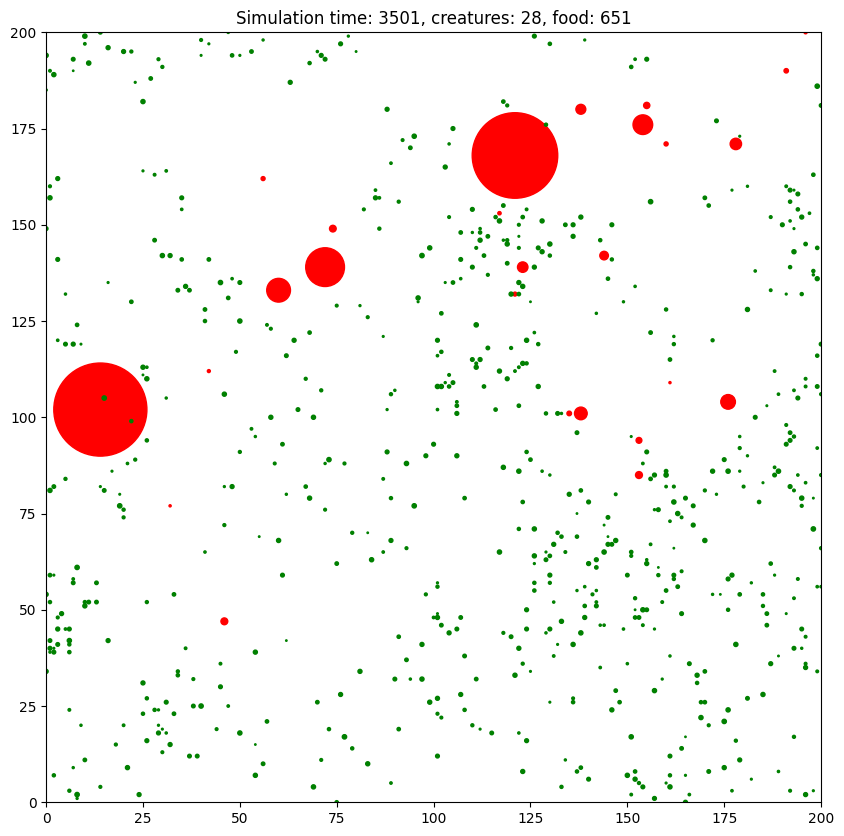

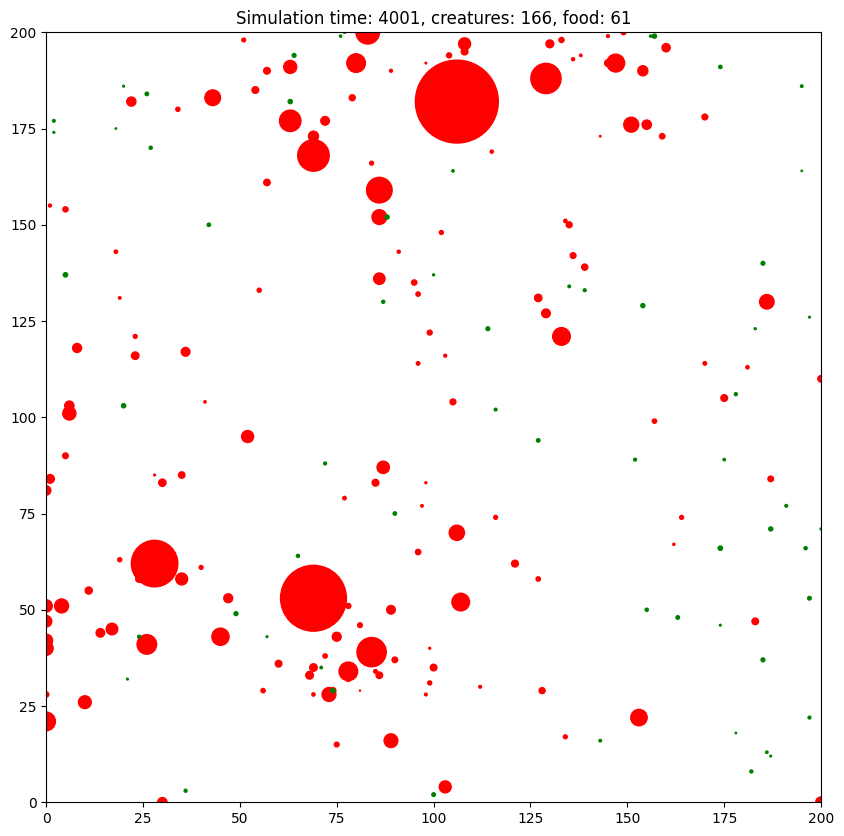

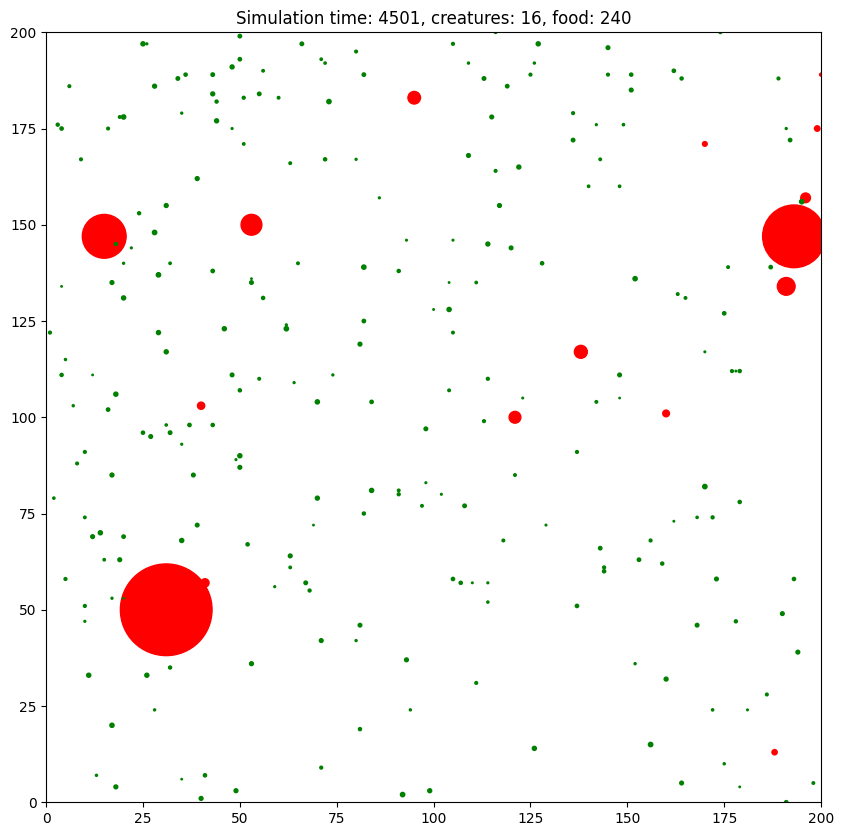

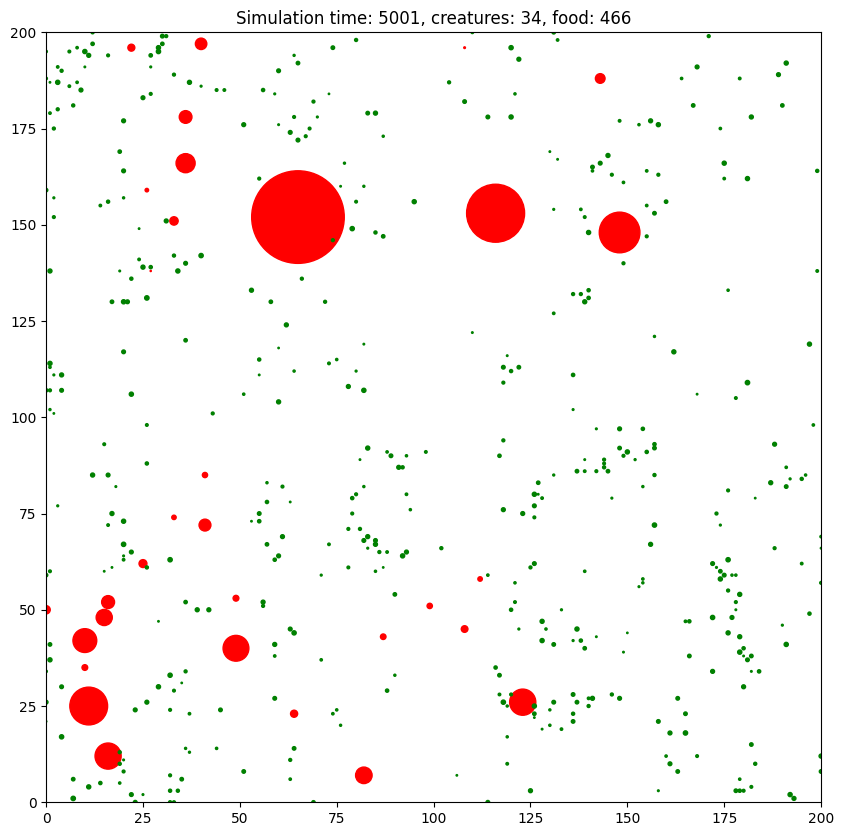

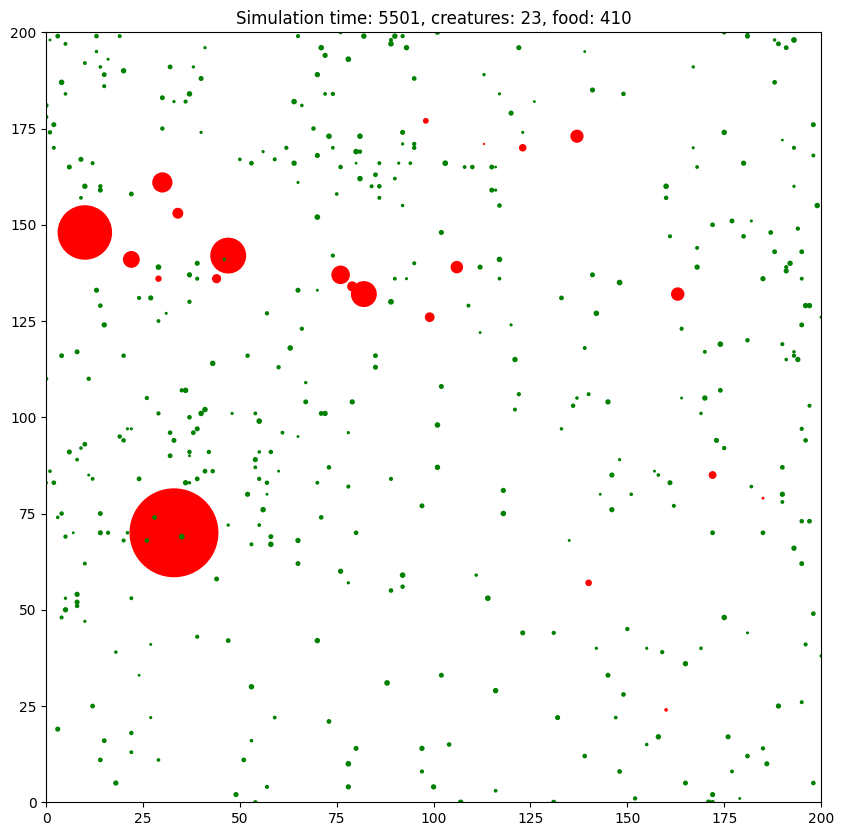

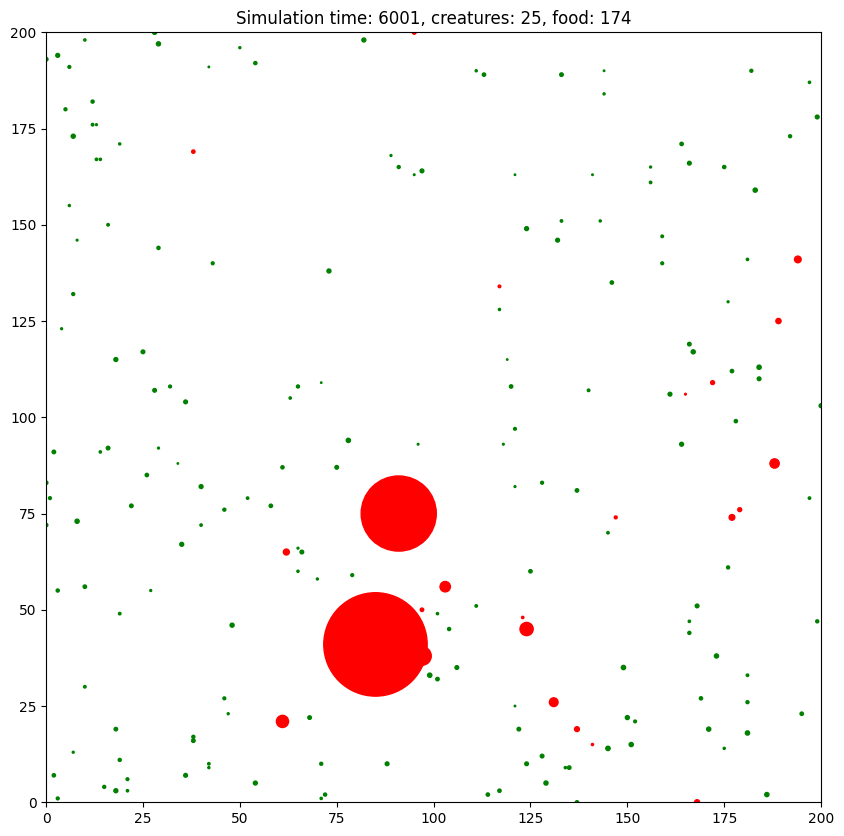

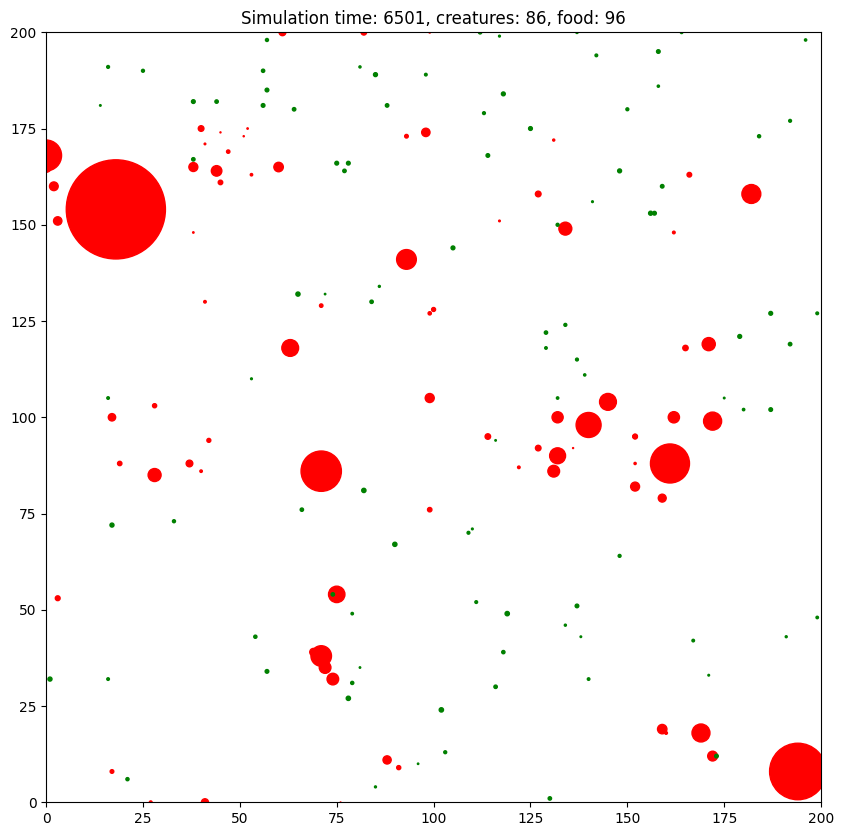

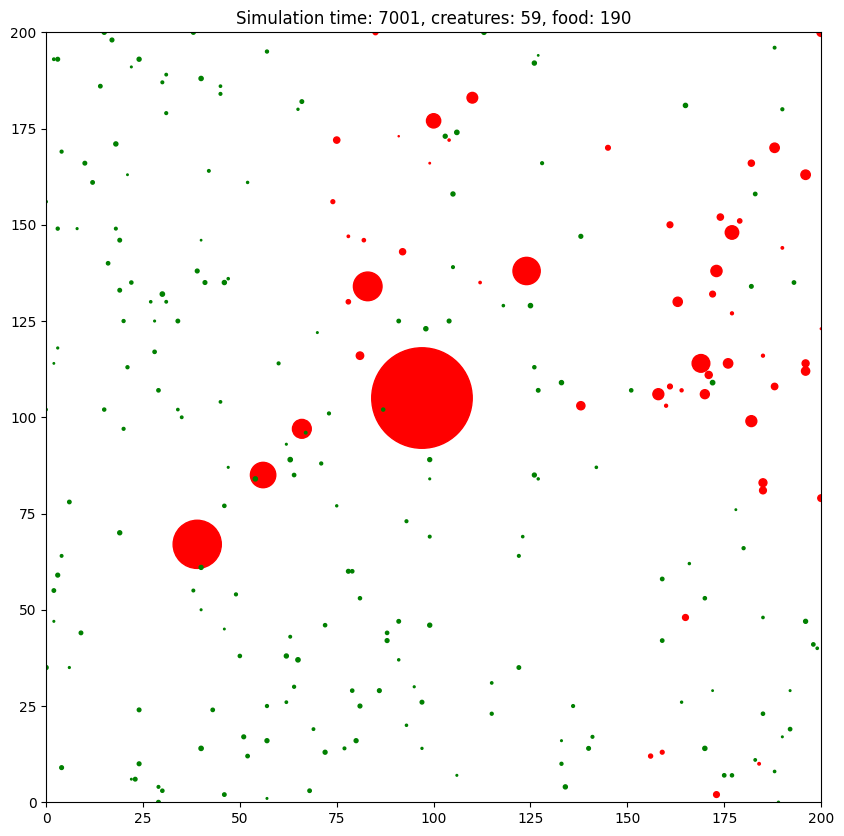

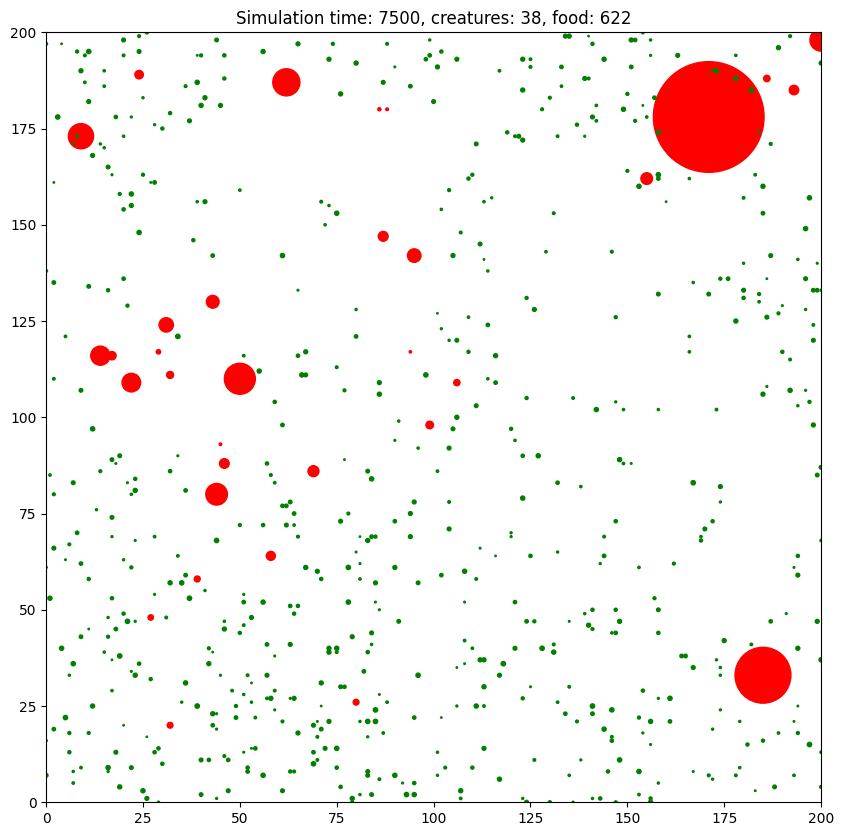

In [216]:
sim = Simulation()
sim.init(10, 1000)
sim.make_plot()
avg = []
zero = []
non_zero = []
for i in range(7500):
    if len(sim.creatures) == 0:
        break
    sim.step()
    avg.append(sim.avg_life_span)
    zero.append(sim.zero_life_span_count)
    non_zero.append(sim.non_zero_life_span_count)
    if i % 500 == 0: 
        sim.make_plot()

sim.make_plot()

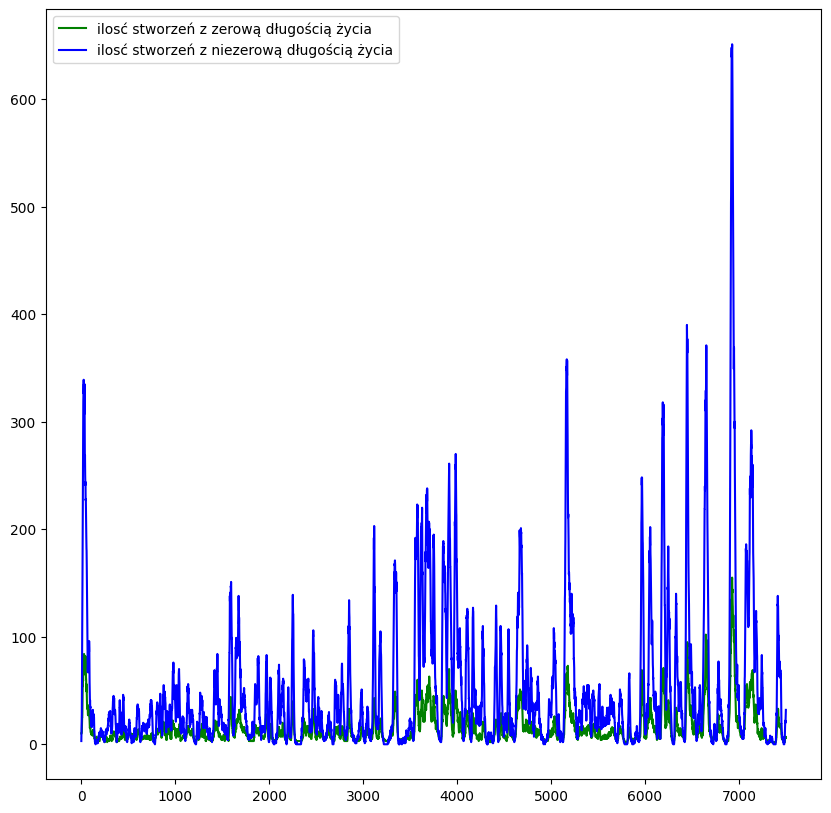

In [220]:
plt.figure(figsize=(10, 10))
plt.plot(zero, color='green')
plt.plot(non_zero, color='blue')
plt.legend(['ilosć stworzeń z zerową długością życia', 'ilosć stworzeń z niezerową długością życia'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

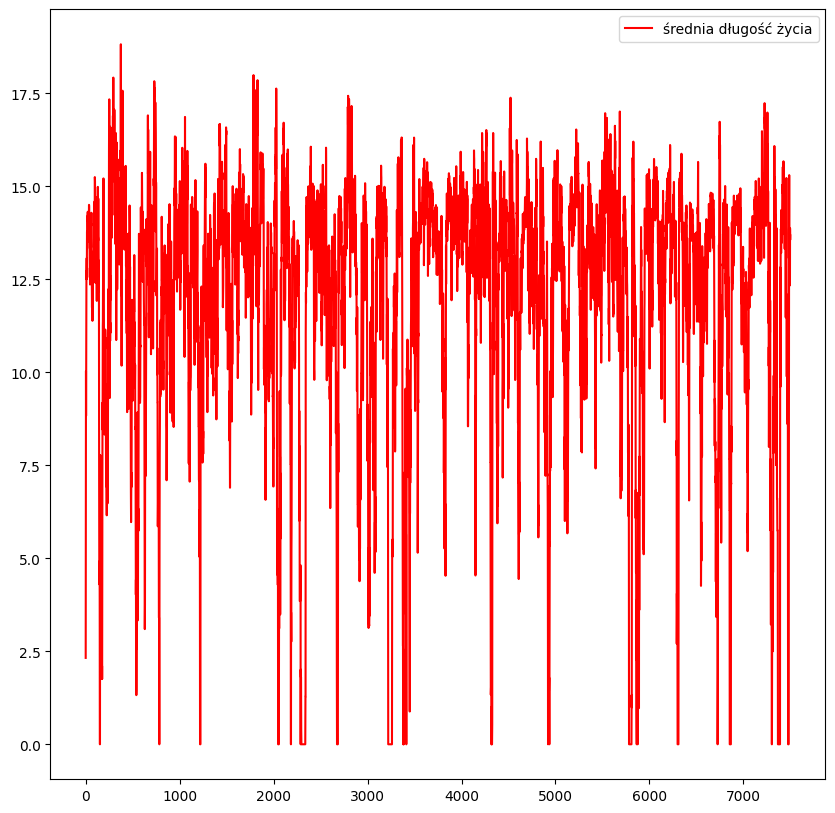

In [221]:
plt.figure(figsize=(10, 10))
plt.plot(avg, color='red')
plt.legend(['średnia długość życia'])
plt.show

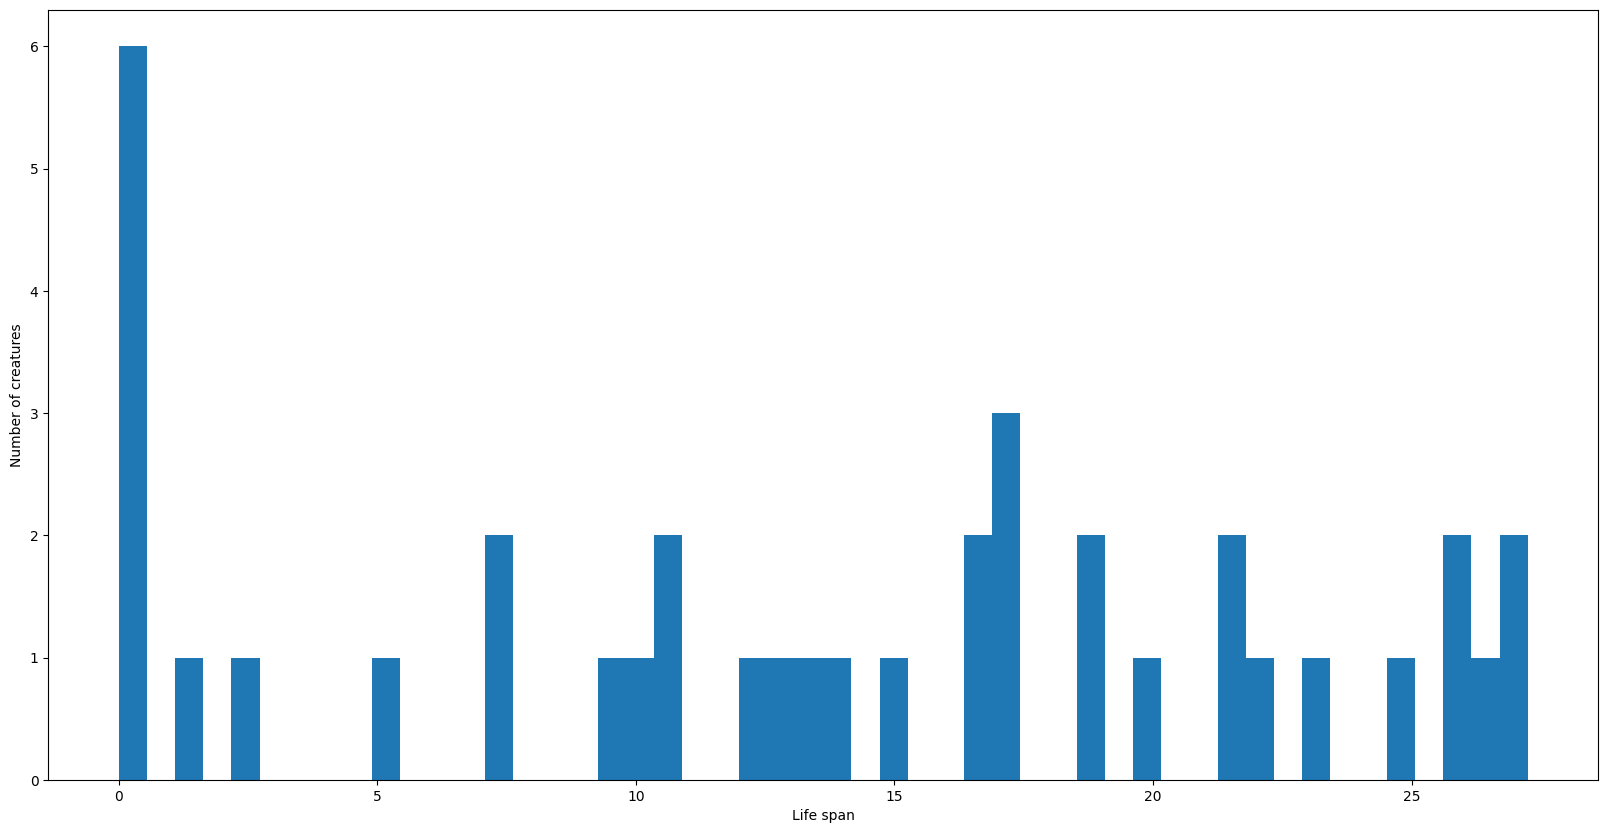

In [222]:
import matplotlib.pyplot as plt

# plot bar graph showing how many creatures of given life span are there
plt.figure(figsize=(20, 10))
plt.hist([c.life_span for c in sim.creatures], bins=50)
plt.xlabel("Life span")
plt.ylabel("Number of creatures")
plt.show()